<a href="https://colab.research.google.com/github/OscarBedford/MLCourse_Weekly_Exercises/blob/main/Exercise_10_9_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

9- analogous to task 4 but predicting continuous subject age

In [ ]:
%%capture
!pip install nilearn

In [ ]:
%%capture
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib

In [ ]:
%%capture
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import BayesianRidge

In [ ]:
%%capture
from IPython import display
display.set_matplotlib_formats('svg')

In [ ]:
# We import the data first in order to select the last 10 subjects
%%capture
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 1) # we fix this to 1
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] # gives subject age on standard units after z-scoring

In [ ]:
# We prepare the X matrix and y vector, and we scale X
X, y = input_variables, output_variable
X_scaled = scaler.fit_transform(X)

In [ ]:
# We create the train-test splits by hand
X_scaled_train = X_scaled[0:90,:]
X_scaled_test = X_scaled[90:100,:]
y_train = y[0:90]
y_test  = y[90:100]

In [ ]:
# We preallocate the variables where we will store the results
ridge_tr_acc = []
ridge_test_acc = []

In [ ]:
# We prepare the ridge model
ridge = Ridge(random_state= 42, solver = "saga")
poly = PolynomialFeatures(degree=2)

# We are ready to iterate through the degree values:
for k in list(range(1,21)):
  
  X_scaled_train = X_scaled[0:90,:]          # We re-instate X_scaled_train so that the initial value is always the same at the start of every iteration
  X_scaled_test = X_scaled[90:100,:]      # Ditto for X_scaled_test

  GMM = GaussianMixture(n_components=(k), random_state=42, max_iter=10000).fit(X_scaled_train, y_train)       # We define the Gaussian Mixture Model and fit it to the training data
  X_scaled_train = GMM.predict_proba(X_scaled_train) # We fit_transform the training data based on n components
  X_scaled_train = poly.fit_transform(X_scaled_train) # We fit_transform the training data to a 2nd degree polynomial 

  X_scaled_test = GMM.predict_proba(X_scaled_test) # We transform the test data without fitting, based on n components
  X_scaled_test = poly.fit_transform(X_scaled_test) # We fit_transform the test data to a 2nd degree polynomial 

  # We fit the ridge model on the transformed data to obtain training accuracies
  ridge.fit(X_scaled_train, y_train)
  score = ridge.score(X_scaled_train, y_train)        # We calculate the scores
  ridge_tr_acc.append(score)                                     # We store the scores

  # We use the .predict method to obtain test accuracies
  ridgePred = ridge.predict(X_scaled_test)       # We predict X_test based on ridge
  score = ridge.score(X_scaled_test, y_test)       # We calculate the scores
  ridge_test_acc.append(score)                             # We store the scores

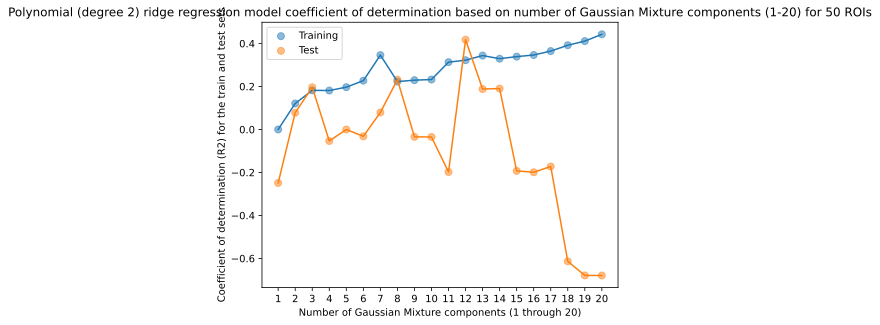

In [ ]:
# We're ready to plot
sample=list(range(1,21))
lab = ['Training', 'Test']
plt.style.use("default")
plt.scatter(sample,ridge_tr_acc, s=50, alpha = 0.5, marker = 'o')
plt.scatter(sample,ridge_test_acc, s=50, alpha = 0.5, marker = 'o')
plt.legend(labels=(lab))
plt.gca().set(
    title="Polynomial (degree 2) ridge regression model coefficient of determination based on number of Gaussian Mixture components (1-20) for 50 ROIs",
    xlabel="Number of Gaussian Mixture components (1 through 20)",
    ylabel="Coefficient of determination (R2) for the train and test sets",
    xticks = (sample)
)
plt.plot(sample,ridge_tr_acc)
plt.plot(sample,ridge_test_acc)
plt.show()